<a href="https://colab.research.google.com/github/thilinadj/Deep-Learning-CW2/blob/kirthika/image_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google drive to save model checkpoints automatically to the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q datasets transformers

     |████████████████████████████████| 451 kB 7.6 MB/s 
     |████████████████████████████████| 5.8 MB 51.6 MB/s 
     |████████████████████████████████| 182 kB 64.1 MB/s 
     |████████████████████████████████| 132 kB 72.2 MB/s 
     |████████████████████████████████| 212 kB 67.5 MB/s 
     |████████████████████████████████| 127 kB 65.4 MB/s 
     |████████████████████████████████| 7.6 MB 48.4 MB/s 


Importing necessary libraries 

In [5]:
import torch
import requests
import numpy as np
from PIL import Image

from datasets import load_dataset 
from datasets import load_metric
from transformers import AutoFeatureExtractor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import DefaultDataCollator
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer


Loading fashion-minst dataset 

In [6]:
dataset = load_dataset("fashion_mnist")

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#loading the metrics accuracy
metric = load_metric("accuracy")

<ipython-input-5-21f3ecd7ee32>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Exploring the dataset

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [8]:
example=dataset["train"][1]

In [ ]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
example['image']

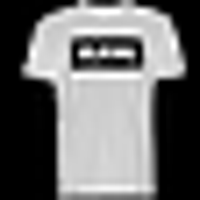

In [ ]:
example['image'].resize((200, 200))

In [ ]:
example['label']

0

In [ ]:
dataset["train"].features["label"]

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [9]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'Pullover'

Feature Extraction -Normalizing the images and rescaling to the same size 

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
feature_extractor

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
#normalizing the images 
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop((224,224)), ToTensor(), normalize])

In [ ]:
def transforms(examples):
    """ tranforming images and returning them to be in the form of input for transformers(pixel values) """
    examples_image["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples_image["image"]]
    del examples_image["image"]
    return examples_image

In [ ]:
transformed_dataset = dataset.with_transform(transforms)

In [ ]:
transformed_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
transformed_dataset['train'][0]

{'label': 9,
 'pixel_values': tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [ 0.5686,  0.5686,  0.5686,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.5686,  0.5686,  0.5686,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.5686,  0.5686,  0.5686,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [ 0.5686,  0.5686,  0.5686,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.5686,  0.5686,  0.5686,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.5686,  0.5686,  0.5686,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],

Defining model configurations and arguments

In [ ]:
#pixel values and labels are keys used in each Batch, DATA_COLLATOR is used to batch these data instances together.
data_collator = DefaultDataCollator()
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True,
)

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#model and batch size is inialized
model_checkpoint='google/vit-base-patch16-224-in21k'
batch_size = 16

#training arguments given and 10 epochs mentioned with a batch size of 16
training_args = TrainingArguments(
    output_dir="./drive/My Drive/hugging_face/results",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [ ]:
#In this compute_metrics function,Tuple is taken as input ,predictions are model logits ,label_ids are lables representings the classes

def compute_metrics(eval_pred):
    """accuracy is calcualted in a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Trainer consists of training and evaluation loop that is used in pytorch for transformers

In [ ]:
#All the arguents passedto trainer with model name

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

Model is trained and evaluated

In [ ]:
#Model is saved after each epoch as checkpoint
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 60000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 9370
  Number of trainable parameters = 85806346


Epoch,Training Loss,Validation Loss,Accuracy
0,0.506600,0.545015,0.831000
1,0.423000,0.389419,0.864500
2,0.325200,0.358537,0.876000
3,0.278300,0.329384,0.885000
4,0.269400,0.316050,0.887600
5,0.232300,0.296499,0.893100
6,0.203500,0.289959,0.895200
7,0.274000,0.293483,0.896500


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
Saving model checkpoint to ./drive/My Drive/hugging_face/results/checkpoint-937
Configuration saved in ./drive/My Drive/hugging_face/results/checkpoint-937/config.json
Model weights saved in ./drive/My Drive/hugging_face/results/checkpoint-937/pytorch_model.bin
Image processor saved in ./drive/My Drive/hugging_face/results/checkpoint-937/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
Saving model checkpoint to ./drive/My Drive/hugging_face/results/checkpoint-1874
Configuration saved in ./drive/My Drive/hugging_face/results/checkpoint-1874/config.json
Model weights saved in ./drive/My Drive/hugging_face/results/checkpoint-1874/pytorch_model.bin
Image processor saved in ./drive/My Drive/hugging_face/results/checkpoint-1874/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
Saving model checkpoint to ./drive/My Drive/huggin

Epoch,Training Loss,Validation Loss,Accuracy
0,0.506600,0.545015,0.831000
1,0.423000,0.389419,0.864500
2,0.325200,0.358537,0.876000
3,0.278300,0.329384,0.885000
4,0.269400,0.316050,0.887600
5,0.232300,0.296499,0.893100
6,0.203500,0.289959,0.895200
7,0.274000,0.293483,0.896500
8,0.197700,0.274072,0.903800
9,0.163400,0.273803,0.904000


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
Saving model checkpoint to ./drive/My Drive/hugging_face/results/checkpoint-8433
Configuration saved in ./drive/My Drive/hugging_face/results/checkpoint-8433/config.json
Model weights saved in ./drive/My Drive/hugging_face/results/checkpoint-8433/pytorch_model.bin
Image processor saved in ./drive/My Drive/hugging_face/results/checkpoint-8433/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
Saving model checkpoint to ./drive/My Drive/hugging_face/results/checkpoint-9370
Configuration saved in ./drive/My Drive/hugging_face/results/checkpoint-9370/config.json
Model weights saved in ./drive/My Drive/hugging_face/results/checkpoint-9370/pytorch_model.bin
Image processor saved in ./drive/My Drive/hugging_face/results/checkpoint-9370/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./drive/

***** train metrics *****
  epoch                    =          10.0
  total_flos               = 43302818779GF
  train_loss               =        0.3659
  train_runtime            =    6:06:43.55
  train_samples_per_second =        27.268
  train_steps_per_second   =         0.426


In [ ]:
#triner loading the best checkpoint and giving evlaution results
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9018
  eval_loss               =     0.2826
  eval_runtime            = 0:02:27.57
  eval_samples_per_second =     67.761
  eval_steps_per_second   =      4.235


Inferencing is doing to make sure no bias in the model 

In [ ]:
#Model and feature extractor is loaded 
folder_name = "./drive/My Drive/hugging_face/results"
feature_extractor = AutoFeatureExtractor.from_pretrained(folder_name)
my_model = AutoModelForImageClassification.from_pretrained(folder_name)

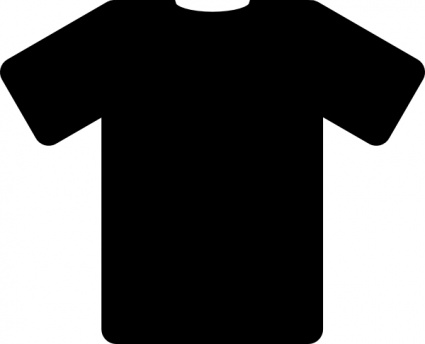

In [ ]:
#image url is given and viewed for predicting purposes
image_url = 'https://png.vector.me/files/images/1/1/119241/black_t_shirt_clip_art.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
# image is preprocessed using feature extractor
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
#getting the output of the model 
with torch.no_grad():
  outputs = my_model(**encoding)
  logits = outputs.logits

In [ ]:
#predicting the input with argmax
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", my_model.config.id2label[predicted_class_idx])

Predicted class: T - shirt / top
